<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">To be or not to be?</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">Binary Classification on Artificial Medical Data</a></center>
<br/>

# <center> Authors: Xavier Bou and Eric Santiago</center>

---


---

# TP1 Instructions


The goal of this TP is to work on a mortality prediction problem and to participate into the "To be or not to be?" challenge.

A fresh instance of the challenge can be found here: https://competitions.codalab.org/competitions/27605

* **Step 1:** Sign up to https://competitions.codalab.org
* **Step 2:** Go through the competition's pages and read them carefully in order to understand the problem.
* **Step 3:** Download the dataset from "Participate > Files > Public Data" page. Put the "public_data" folder in the same folder as the folder containing this notebook.
* **Step 4:** Go though this notebook. You'll have to read, run, **code your own methods** and **answer quetions**. Use "code" cell for coding and "markdown" cell to answer questions. 

_Remark: You may need to look up on the internet for information or documentation._

<b><font size="5">Outline</font></b><br/><br/>
&emsp;&emsp;&emsp; I) <a href="#data"> Load data</a><br/>
&emsp;&emsp;&emsp; II) <a href="#exploratory"> Exploratory analysis </a><br/>
&emsp;&emsp;&emsp; III) <a href="#processing"> Processing </a><br/>
&emsp;&emsp;&emsp; IV) <a href="#model"> Predictive model </a><br/>
&emsp;&emsp;&emsp; V) <a href="#save"> Save predictions </a><br/>

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import time
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
%matplotlib inline
import seaborn as sns

sns.set()
# IMPORTS
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
)

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


### Question 1: Briefly explain the task.

The task consists in designing and training a model to predict whether future hospital patients will either die or live, based on the provided training data. We should explore different approaches (hyperparameter tuning, differetn models, data resampling...) to improve and find out the best solution

### Question 2: What is the metric used in the challenge?

We are dealing with skewed classes, as there are only a few samples from patients that died, compared to the amount of data representing patients that lived. Therefore, using accuracy might not be the best metric to evaluate the model performance (We could predict that they all live and have a good accuracy).

For this reason, the models are evaluated using the balanced accuracy metric (the average recall obtained on either class), taking account the classes distribution.

## <a id="data"> I) Load data</a>  

In [ ]:
features = pd.read_csv(
    "/content/public_data/mimic_synthetic_feat.name", header=None
).values.flatten()
labels = pd.read_csv(
    "/content/public_data/mimic_synthetic_label.name", header=None
).values.flatten()
X = pd.read_csv(
    "/content/public_data/mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)
y = pd.Series(
    pd.read_csv(
        "/content/public_data/mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [ ]:
X.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,SYS_BP_MIN_DAY1,SYS_BP_MAX_DAY1,SYS_BP_MEAN_DAY1,DIAS_BP_MIN_DAY1,DIAS_BP_MAX_DAY1,DIAS_BP_MEAN_DAY1,MEAN_BP_MIN_DAY1,MEAN_BP_MAX_DAY1,MEAN_BP_MEAN_DAY1,RESP_RATE_MIN_DAY1,RESP_RATE_MAX_DAY1,RESP_RATE_MEAN_DAY1,TEMP_MIN_DAY1,TEMP_MAX_DAY1,TEMP_MEAN_DAY1,SPO2_MIN_DAY1,SPO2_MAX_DAY1,SPO2_MEAN_DAY1,GLUCOSE_MIN_DAY1,GLUCOSE_MAX_DAY1,GLUCOSE_MEAN_DAY1,HR_MIN_DAY2,HR_MAX_DAY2,HR_MEAN_DAY2,SYS_BP_MIN_DAY2,SYS_BP_MAX_DAY2,...,Attention-deficit/conduct/disruptivebeha,Delirium/dementia/amnestic/othercognitiv,Developmentaldisorders,Disordersusuallydiagnosedininfancy/ch,ImpulsecontroldisordersNEC,Mooddisorders,Personalitydisorders,Schizophreniaandotherpsychoticdisorde,Alcohol-relateddisorders,Substance-relateddisorders,Suicideandintentionalself-inflictedin,Screeningandhistoryofmentalhealthan,Miscellaneousmentaldisorders,Viralinfect,Meningitis,Encephalitis,OthCNSinfx,Parkinson-s,Othinfectns,MS,OtheredCNS,Paralysis,Epilepsy/cnv,Headache/mig,Coma/brndmg,Cataract,Retinaldx,Glaucoma,Blindness,SexualInfxs,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,45524,108398,2128-05-15_23:42:00,2132-07-23_15:00:00,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.207630,108.704030,70.841980,79.847060,119.72417,94.435090,26.880910,68.876540,48.665768,37.614445,83.690080,61.041763,9.086277,24.325495,15.317726,34.627020,37.500460,37.149044,88.517360,98.391525,99.372050,134.743700,217.31165,155.57593,68.142490,100.063774,78.120926,89.537865,117.834885,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0
1,50520,186416,2134-03-17_03:59:00,2113-03-06_12:05:00,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.331400,121.138664,96.915726,93.994540,138.59406,113.570206,38.621536,74.270065,66.566760,62.047737,98.244140,81.589250,8.950318,20.452858,16.422120,36.979280,37.946106,37.567726,94.895510,99.241165,98.645110,117.071846,152.38774,140.82172,89.746510,106.236690,101.622210,95.438126,145.642680,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1
2,17956,126413,2164-04-05_17:32:00,2180-09-20_16:30:00,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118.230290,175.175430,140.936700,122.862610,144.25964,134.501220,67.754650,83.301410,80.350330,76.247795,105.058030,98.625850,14.516378,39.715710,23.086393,36.951508,38.752600,38.071655,95.166626,99.261380,93.118576,108.634170,247.39170,129.60728,125.785750,174.718640,141.342070,133.556170,132.174180,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0
3,90258,109355,2102-09-08_00:58:00,2166-06-26_15:30:00,Medicare,ENGL,NOT_SPECIFIED,MARRIED,WHITE,M,75,83.780380,89.188980,86.051155,111.390740,144.86057,127.681170,61.139935,75.232390,74.849920,80.639640,106.473175,93.559380,13.452833,21.236153,15.556414,36.293858,37.254100,37.034706,86.604610,96.742004,94.456890,191.599600,228.56810,228.90790,68.780624,114.619530,90.120900,92.589430,120.602905,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0
4,25159,123784,2163-08-06_12:07:00,2147-01-14_18:40:00,Medicare,ENGL,UNOBTAINABLE,MARRIED,UNKNOWN/NOT_SPECIFIED,F,55,60.878613,105.637500,80.616840,87.627464,127.75874,99.098860,42.693020,64.015396,64.309480,62.921795,98.436676,76.924060,8.615975,18.557594,12.778845,35.965570,36.973774,36.258358,61.632220,98.825516,99.040010,128.833010,181.92357,142.89526,56.715332,83.016860,76.610200,91.593130,117.402180,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0


This is the **training set**. This means that have access to the labels and you can use it in anyway you want to prepare your model.

Later on, you'll make your model draws predictions from the **testing set** in order to upload them on Codalab and get a score on unseen labels.

In [ ]:
# Load testing set
X_test = pd.read_csv(
    "/content/public_data/mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

## <a id="exploratory"> II) Exploratory analysis</a>

#### Variable types

In [ ]:
types = pd.read_csv(
    "/content/public_data/mimic_synthetic_feat.type", header=None
).set_index(features)[0]
print(types.value_counts())

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64


#### Labels distribution

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


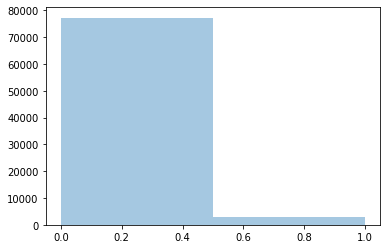

In [ ]:
sns.distplot(y, bins=2, kde=False)

### Code 1: Display the following plots:
* Bar plots of some categorical variables (e.g. "LANGUAGE", "MARITAL_STATUS")

* Show the correlation between some variables and the target variable y.

* Another plot or any exploratory analysis you can think of

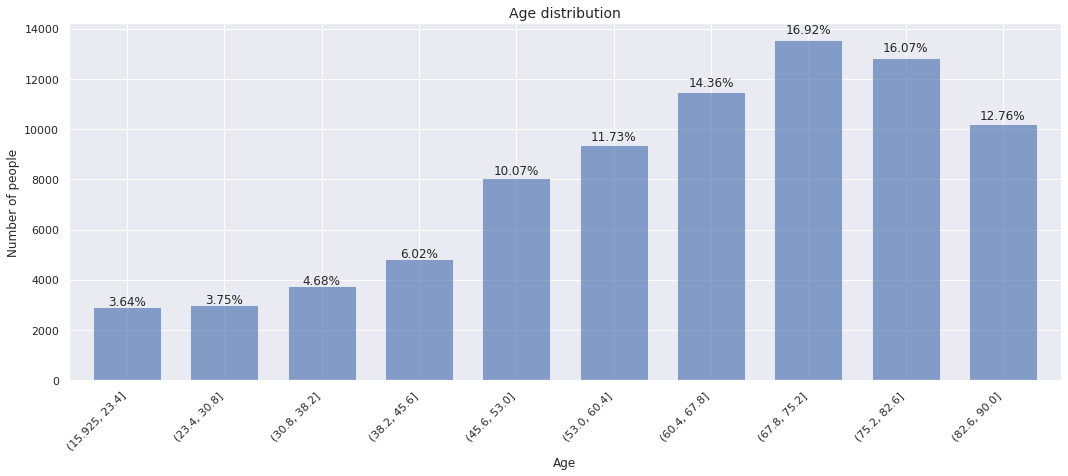

In [ ]:
ax = X['AGE'].value_counts(sort = False, bins = 10).plot(kind='bar',figsize=(15,7), width = 0.70, alpha = 0.65)
ax.set_title("Age distribution", fontdict={'fontsize':14})
ax.set_xlabel("Age", fontdict={'fontsize':12})
ax.set_ylabel("Number of people", fontdict={'fontsize':12})
plt.tight_layout()
plt.xticks(rotation=45, ha="right")
for p in ax.patches:
        total = X.shape[0]
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(percentage, (x + width/2, y + height*1.02), ha='center')

In [ ]:
X.corrwith(y)

SUBJECT_ID    -0.004639
HADM_ID       -0.002889
AGE            0.019190
HR_MIN_DAY1    0.064780
HR_MAX_DAY1    0.072596
                 ...   
Othnervdx      0.022230
Hrtvalvedx    -0.024616
Carditis      -0.003771
HTN            0.001889
Htncomplicn   -0.008553
Length: 332, dtype: float64

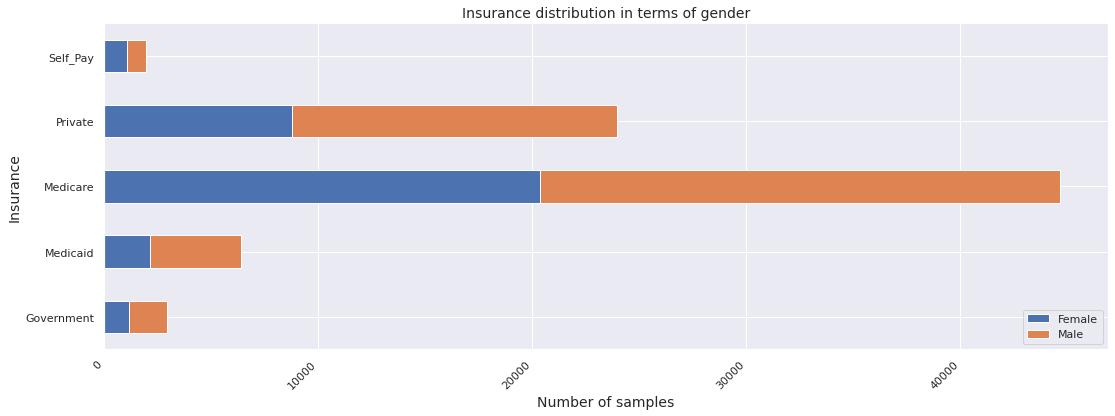

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
labels = ['Female','Male']
X.groupby(['INSURANCE','GENDER'])['GENDER'].count().unstack('GENDER').plot.barh(stacked=True, width=0.5,  ax=ax)
plt.legend(loc="lower right", labels=labels)
ax.set_title("Insurance distribution in terms of gender", fontdict={'fontsize':14})
ax.set_xlabel("Number of samples", fontdict={'fontsize':14})
ax.set_ylabel("Insurance", fontdict={'fontsize':14})
plt.xticks(rotation=45, ha="right")
plt.show()

You can use markdown cells to add interesting comments.

## <a id="processing"> Class definition</a>

In order to reach a factored, cleaner code, we will define a class to process the data and tune the hyperparameters of the model. We will define the class down below, with some functions to make our life easier.

In [ ]:
# This class has been defined with the purpose of assisting the processing and
# hyperparameter tuning of the data, having a cleaner and organized code
class dataHandler(object):

  def __init__(self, X, y, X_test):
    self.X = X
    self.y = y
    self.X_test = X_test
  


  # This method encodes the categorical features into numerical features using a
  # LabelEncoder, and then replaces the NaN values with the desired strategy
  def preprocess(self, strategy):
    X_enc = self.X.copy()
    X_test_enc = self.X_test.copy()
    objList = X_enc.select_dtypes(include = "object").columns
    print (objList)

    #Label Encoding for object to numeric conversion
    le = LabelEncoder()

    for feat in objList:
        le.fit(X_enc[feat].astype(str))
        X_enc[feat] = le.transform(X_enc[feat].astype(str))
        X_test_enc[feat] = X_test_enc[feat].map(lambda s: '<unknown>' if s not in le.classes_ else s)
        le.classes_ = np.append(le.classes_, '<unknown>')
        X_test_enc[feat] = le.transform(X_test_enc[feat].astype(str))
    
    # Remove NaN values and replace them by the specified strategy
    imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imp.fit(X_enc)
    X_no_nan = imp.transform(X_enc)
    X_test_no_nan =  imp.transform(X_test_enc)

    return X_no_nan, X_test_no_nan
  



  # This class resamples (upsample or downsample) the data to adjust the number 
  # of samples of each class to num_class_0 and num_class_1
  def resample (self, X, y, num_class_0, num_class_1):

    # Separate class 0 samples and class 1 samples
    X_class_0 = X[y==0]
    X_class_1 = X[y==1]
    #print('Number of original class 0 samples: ', len(X_class_0))
    #print('Number of original class 1 samples: ', len(X_class_1))

    # Check whether replacement is necessary
    class_0_replace = False
    class_1_replace = False
    if num_class_0 > len(X_class_0):
      class_0_replace = True
    if num_class_1 > len(X_class_1):
      class_1_replace = True

    # Resample classes separately
    X_class_0_resampled = resample(X_class_0, replace=class_0_replace, n_samples= num_class_0)
    X_class_1_resampled = resample(X_class_1, replace=class_1_replace, n_samples= num_class_1)

    #print('New number of class 0 samples: ', len(X_class_0_resampled))
    #print('New number of class 1 samples: ', len(X_class_1_resampled))

    # Concatenate and return new resampled data
    X_resampled = np.concatenate((X_class_1_resampled, X_class_0_resampled), axis=0)
    y_resampled = np.concatenate((np.ones(len(X_class_0_resampled)), np.zeros(len(X_class_1_resampled))), axis=0)

    return X_resampled, y_resampled

## <a id="processing"> III) Processing</a>

As you may have noticed, various variables are categorical and encoded with strings. Most models won't be able to take them as input.

### Code 2: Transform the categorical data into integers using the encoding of your choice.

_Hint: The simplest methods is called "Label Encoding". It simply consists in replacing each new category you encounter by the integer, starting from 0. It may not be the most efficient method._

In [ ]:
# We define an object of our class dataHandler, and use the preprocess method
dataHandler = dataHandler(X,y,X_test)
X_no_nan, X_test_no_nan = dataHandler.preprocess('median')


Index(['ADMITTIME', 'DISCHTIME', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'GENDER', 'ICU'],
      dtype='object')


## <a id="model"> IV) Predictive model</a>

Train a model and assess its performance.

In [ ]:
# Baseline: Random Forest
clf = RandomForestClassifier(n_estimators=10)
x_train, x_valid, y_train, y_valid = train_test_split(
    X_no_nan, y, test_size=0.3
)  # train/validation split
clf.fit(x_train, y_train)  # training
y_pred = clf.predict(x_valid)  # predictions
score = balanced_accuracy_score(y_valid, y_pred)  # scoring
print("Balanced accuracy score: {}".format(score))

# Analyze prediction with Confusion Matrix
conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

Balanced accuracy score: 0.5005772327959379
Confusion matrix:
 [[23192     2]
 [  805     1]]


### Code 3: the code above uses a simple "hold out" method to get the validation score. Use cross-validation to get a more stable estimation.

In [ ]:
y_pred = cross_val_score(clf, X_no_nan, y, cv=10)
print("Cross-validation accuracy score: {}".format(np.mean(score)))

Cross-validation accuracy score: 0.5005557539955487


### Code 4: Try to improve your score by using at least one of the following methods:

* Hyperparameter search
* Model selection
* Data augmentation

## <a id="model"> Improving Random Forest Classifier</a>

### Data Resampling

The first approach we'll try to improve the classifier is to resample the data and even the samples from class 1 and 0. To upsample the minority class, we will have to randomly add samples from the already small batch size of that class, so we have to be careful to avoid overfitting.

Thus, we will first evaluate the accuracy score at different sizes of the data, and then we will evaluate the confusion matrix to avoid overfitting and find an good resampling size for our data.

It is important to set aside the validation data before resizing, because when upsampling we will use already existing point of the data to increase the size of the class. This way, the accuracy on the validation set could be misleading if we don't separate validation and train before the resampling.


In [ ]:
# This class evaluates the performance of the Random Forest Classifier for 
# multiple sizes of the data, by resampling it to have the same number of samples
# for both classes.
def resample_analysis(dataHandler, X, y , class_N, n_estimators):
  acc_val = []
  acc_train = []
  n_class = []

  for n in class_N:
    X_resampled, y_resampled = dataHandler.resample (x_train, y_train, n, n);
    clf = RandomForestClassifier(n_estimators=n_estimators)
    clf.fit(X_resampled, y_resampled)  # training

    y_pred_val = clf.predict(x_valid)  # predictions
    y_predict_train = clf.predict(x_train)

    score_val = balanced_accuracy_score(y_pred_val, y_valid)  # scoring
    score_train = balanced_accuracy_score(y_predict_train, y_train)

    acc_val.append(score_val)
    acc_train.append(score_train)
    n_class.append(n)
  
  plt.plot(n_class, acc_val, 'r',  label='Validation Accuracy')
  plt.plot(n_class, acc_train, 'b', label='Train Accuracy')
  plt.legend()
  plt.ylabel('Balanced Accuracy Score')
  plt.xlabel('Number of Samples per Class')
  plt.title("Data resampling analysis with n_estimators = %d" % n_estimators)
  plt.show()

  print("Best Accuracy score: {} (at {} samples per class)".format(max(acc_val), n_class[acc_val.index(max(acc_val))]))

  return acc_val,n_class

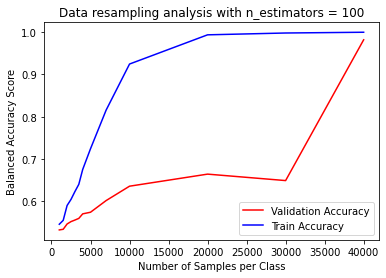

Best Accuracy score: 0.9821242551772991 (at 40000 samples per class)


In [ ]:
class_N = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 5000, 7000, 10000, 20000, 30000, 40000]
acc,n_class = resample_analysis(dataHandler,X_no_nan, y, class_N, 100)

Although the results seem to be very good for a high number of samples per class, we found two sensitive points that we need to consider:


*   When separating validation set before resampling, the class 1 is still very misrepresented (skewed) and assigning all samples to class 0 yields a good result anyways.
*   When resampling first and then dividing the data into validation and train sets, the validation set contains data from the train set due to the resampling process.

Therefore, we decided to resample the data to the amount of given class 1 samples



In [ ]:
N = len(X_no_nan[y==1])
X_resampled, y_resampled = dataHandler.resample (X_no_nan, y, N , N);
x_train, x_valid, y_train, y_valid = train_test_split(
    X_resampled, y_resampled, test_size=0.3)

print("Resampled data size: {}".format(X_resampled.shape[0]))

clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)  # training

y_pred_val = clf.predict(x_valid)  # predictions
y_predict_train = clf.predict(x_train)

score_val = balanced_accuracy_score(y_pred_val, y_valid)  # scoring
score_train = balanced_accuracy_score(y_predict_train, y_train)

print("Balanced accuracy score: {}".format(score_val))

# Analyze prediction with Confusion Matrix
conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred_val)
print('Confusion matrix:\n', conf_mat)

Resampled data size: 5594
Balanced accuracy score: 0.7021569331214002
Confusion matrix:
 [[609 220]
 [282 568]]


### PCA analysis

Now, let's see how PCA affects our model. Let's evaluate the performance we obtain for different numbers of principal components. For this, we have written the function down below:

In [ ]:
def pca_evaluation(X, y, n_estimators, nComp_range):
  # Initialize arrays to record the results for each iteration
  train_acc = []
  validation_acc = []
  nComp_values = []

  x_train, x_valid, y_train, y_valid = train_test_split(
      X, y, test_size=0.3
  )  # train/validation split

  # Initialize model
  clf = RandomForestClassifier(n_estimators=n_estimators)

  for i in nComp_range:
    # Apply PCA to the train and validation sets
    preProc = PCA(n_components=i, copy=True)
    preProc.fit(x_train)
    X_train_T = preProc.transform(x_train)
    X_validation_T = preProc.transform(x_valid)

    # Fit model
    clf.fit(X_train_T, y_train)

    # Compute predictions for both train and validation sets
    y_pred_train = clf.predict(X_train_T)
    y_pred_validation = clf.predict(X_validation_T)

    # Record results
    train_acc.append(balanced_accuracy_score(y_train, y_pred_train))
    validation_acc.append(balanced_accuracy_score(y_valid, y_pred_validation))
    nComp_values.append(i)
  
  # Plot the results
  plt.plot(nComp_values, train_acc, 'b',  label='Train Accuracy')
  plt.plot(nComp_values, validation_acc, 'r', label='Validation Accuracy')
  plt.legend()
  plt.ylabel('Accuracy')
  plt.xlabel('Number of Principal Components (nComp)')
  plt.title("PCA Analysis for Decision Tree Classifier with n_estimators = %d" % n_estimators)
  plt.show()

  print("Max train accuracy score: {} (at nComps = {})".format(max(train_acc), nComp_values[train_acc.index(max(train_acc))]   ))
  print("Max validation accuracy score: {} (at nComps = {})\n".format(max(validation_acc), nComp_values[validation_acc.index(max(validation_acc))] )) 

  return train_acc, validation_acc, nComp_values


To run the function, we will remove the first 8 features of our data, because they account for ids, record date, and other information that is not really relevant to the problem.

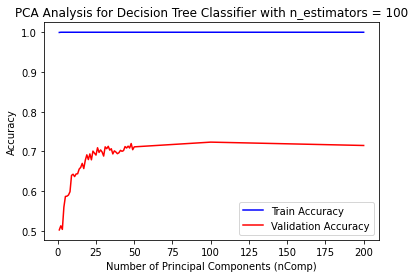

Max train accuracy score: 1.0 (at nComps = 2)
Max validation accuracy score: 0.7235058975115793 (at nComps = 100)



In [ ]:
pca_range = np.array(list(np.arange(1,50))+[50,100,200])
n_estimators = 100
train_acc, validation_acc, nComp_values = pca_evaluation(X_resampled[:,8:], y_resampled, n_estimators, pca_range)

We can see how the best results were obtained for PCA with 100 principal components

### Tuning of n_estimators

Now, let's go on and try to tune the hyperparameter n_estimators

In [ ]:
# Evaluate the Accuracy score for multiple values of max_depth
def max_depth_tune(X, y, n_estimators_range, nComps):
  # Initialize arrays to record the results for each iteration
  train_acc = []
  validation_acc = []

  x_train, x_valid, y_train, y_valid = train_test_split(
      X, y, test_size=0.3
  )  # train/validation split
  # Apply PCA to the train and validation sets
  preProc = PCA(n_components=nComps, copy=True)
  preProc.fit(x_train)
  X_train_T = preProc.transform(x_train)
  X_validation_T = preProc.transform(x_valid)

  for i in n_estimators_range:
    clf = RandomForestClassifier(n_estimators=i)
    clf.fit(x_train, y_train)  # training

    # Compute predictions for both train and validation sets
    y_pred_train = clf.predict(x_train)
    y_pred_validation = clf.predict(x_valid)

    # Record results
    train_acc.append(balanced_accuracy_score(y_train, y_pred_train))
    validation_acc.append(balanced_accuracy_score(y_valid, y_pred_validation))
  
  # Plot the results
  plt.plot(n_estimators_range, train_acc, 'b',  label='Train Accuracy')
  plt.plot(n_estimators_range, validation_acc, 'r', label='Validation Accuracy')
  plt.legend()
  plt.ylabel('Accuracy')
  plt.xlabel('n_estimators')
  plt.title('Accuracy score for n_estimators hyperparameter tuning')
  plt.show()

  print("Max train accuracy score: {} (at n_estimators = {})".format(max(train_acc), n_estimators_range[train_acc.index(max(train_acc))]   ))
  print("Max validation accuracy score: {} (at n_estimators = {})".format(max(validation_acc), n_estimators_range[validation_acc.index(max(validation_acc))] )) 

  return train_acc, validation_acc

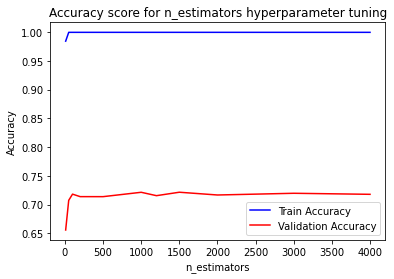

Max train accuracy score: 1.0 (at n_estimators = 50)
Max validation accuracy score: 0.7214127581068616 (at n_estimators = 1500)


In [ ]:
n_estimators_range = [10, 50, 100, 200, 500, 1000, 1200, 1500, 2000, 3000, 4000]
nComps = 100
train_acc, validation_acc = max_depth_tune(X_resampled[:,8:], y_resampled, n_estimators_range, nComps)

The best case was for n_estimators = 1500, atlhough there is not much of a difference for n_estimators > 100.

Let's check if normalization helps us out.

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(
    X_resampled[:,8:], y_resampled, test_size=0.3)

# Normalize the data
scaler = StandardScaler().fit(x_train)
X_train_norm = scaler.transform(x_train)
X_valid_norm = scaler.transform(x_valid)

# Apply PCA
nComps = 100
preProc = PCA(n_components=nComps, copy=True)
preProc.fit(X_train_norm)
X_train_T = preProc.transform(X_train_norm)
X_validation_T = preProc.transform(X_valid_norm)

# Train model
clf = RandomForestClassifier(n_estimators=1500)
clf.fit(X_train_T, y_train)  # training

# Compute predictions for both train and validation sets
y_pred_validation = clf.predict(X_validation_T)
score_val = balanced_accuracy_score(y_valid, y_pred_validation)
print("Balanced accuracy score: {}".format(score_val))

# Analyze prediction with Confusion Matrix
conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred_validation)
print('Confusion matrix:\n', conf_mat)

Balanced accuracy score: 0.7323663552356734
Confusion matrix:
 [[584 263]
 [187 645]]


It did help a bit. Therefore, our best result for Random Forest Classifier is given for:
PCa with 100 principal components, downsampling the class 0 data to the 

*   Downsampling the class 0 data to the same length as class 1 data
*   PCA with 100 Principal Components
*   n_estimators = 1500
*   Normalizing with StandardScaler befor applying PCA

Before trying a different model, let's compute cross-validation for this case

In [ ]:
X_norm = scaler.transform(X_resampled[:,8:])
X_T = preProc.transform(X_norm)
y_pred = cross_val_score(clf, X_T, y_resampled, cv=5)
print("Cross-validation accuracy score: {}".format(np.mean(score)))

Cross-validation accuracy score: 0.6724458748209023


## <a id="model"> Trying other models</a>

### SVM

In [ ]:
# First guess with SVM
c=750
clf = SVC(C=c, kernel='poly')
x_train, x_valid, y_train, y_valid = train_test_split(
    X_resampled[:,8:], y_resampled, test_size=0.3
)  # train/validation split
clf.fit(x_train, y_train)  # training
y_pred = clf.predict(x_valid)  # predictions
score = balanced_accuracy_score(y_valid, y_pred)  # scoring
print("Balanced accuracy score: {}".format(score))
print('C', c)

Balanced accuracy score: 0.7693629358986743
C 750


In [ ]:
y_pred = cross_val_predict(clf, X_resampled, y_resampled, cv=5)
score = balanced_accuracy_score(y_resampled, y_pred)  # scoring
print("Balanced accuracy score: {}".format(score))

conf_mat = confusion_matrix(y_resampled, y_pred)
print('Confusion matrix:\n', conf_mat)

Balanced accuracy score: 0.5377189846263855
Confusion matrix:
 [[1247 1550]
 [1036 1761]]


Hyperparameter tuning for SVM:

Balanced accuracy score: 0.5
C 1e-05
Balanced accuracy score: 0.5
C 0.001
Balanced accuracy score: 0.6369597791014788
C 0.1
Balanced accuracy score: 0.7039629818883779
C 1
Balanced accuracy score: 0.7199311715035833
C 10.0
Balanced accuracy score: 0.7504299457956125
C 1000.0
Balanced accuracy score: 0.721208479020979
C 100000.0


[]

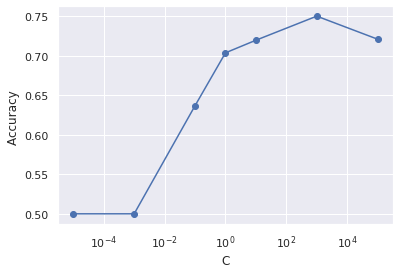

In [ ]:
# Hyperparameter search

cs=[1e-5,1e-3,1e-1,1,1e1,1e3,1e5]
accuracies = []
for c in cs:
    clf = SVC(C=c, kernel='poly')
    x_train, x_valid, y_train, y_valid = train_test_split(
        X_resampled[:,8:], y_resampled, test_size=0.3
    )  # train/validation split
    clf.fit(x_train, y_train)  # training
    y_pred = clf.predict(x_valid)  # predictions
    score = balanced_accuracy_score(y_valid, y_pred)  # scoring
    accuracies.append(score)
    print("Balanced accuracy score: {}".format(score))
    print('C', c)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy ')
plt.plot(cs,accuracies, 'bo-')
plt.plot()

Balanced accuracy score: 0.7450987492331811
C 100
Balanced accuracy score: 0.7495115398705581
C 300
Balanced accuracy score: 0.7681186469063752
C 500
Balanced accuracy score: 0.7582333226440849
C 750
Balanced accuracy score: 0.7307799846149042
C 1000
Balanced accuracy score: 0.74904474974574
C 3000
Balanced accuracy score: 0.7485710839612334
C 5000


[]

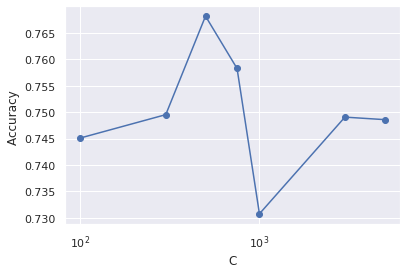

In [ ]:
cs=[100,300,500,750,1000,3000,5000]
accuracies = []
for c in cs:
    clf = SVC(C=c, kernel='poly')
    x_train, x_valid, y_train, y_valid = train_test_split(
        X_resampled[:,8:], y_resampled, test_size=0.3
    )  # train/validation split
    clf.fit(x_train, y_train)  # training
    y_pred = clf.predict(x_valid)  # predictions
    score = balanced_accuracy_score(y_valid, y_pred)  # scoring
    accuracies.append(score)
    print("Balanced accuracy score: {}".format(score))
    print('C', c)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy ')
plt.plot(cs,accuracies, 'bo-')
plt.plot()

In [ ]:
# Final SVM MODEL

c=500
clf = SVC(C=c, kernel='poly')
x_train, x_valid, y_train, y_valid = train_test_split(
    X_resampled[:,8:], y_resampled, test_size=0.3
)  # train/validation split
clf.fit(x_train, y_train)  # training
y_pred = clf.predict(x_valid)  # predictions
score = balanced_accuracy_score(y_valid, y_pred)  # scoring
print("Balanced accuracy score: {}".format(score))
print('C', c)

Balanced accuracy score: 0.757990430214639
C 500


### Other models

In [ ]:
# Baseline: K-NN
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=300)
x_train, x_valid, y_train, y_valid = train_test_split(
    X_resampled[:,8:], y_resampled, test_size=0.3
)  # train/validation split
clf.fit(x_train, y_train)  # training
y_pred = clf.predict(x_valid)  # predictions
score = balanced_accuracy_score(y_valid, y_pred)  # scoring
print("Balanced accuracy score: {}".format(score))

Balanced accuracy score: 0.6293760819593042


In [ ]:
# Baseline: Linear Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1', solver= 'liblinear', C=100, max_iter=1000)
x_train, x_valid, y_train, y_valid = train_test_split(
    X_resampled[:,8:], y_resampled, test_size=0.3
)  # train/validation split
clf.fit(x_train, y_train)  # training
y_pred = clf.predict(x_valid)  # predictions
score = balanced_accuracy_score(y_valid, y_pred)  # scoring
print("Balanced accuracy score: {}".format(score))

Balanced accuracy score: 0.7402544501815271


In [ ]:
# Baseline: GBM
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=500)
x_train, x_valid, y_train, y_valid = train_test_split(
    X_resampled[:,8:], y_resampled, test_size=0.3
)  # train/validation split
clf.fit(x_train, y_train)  # training
y_pred = clf.predict(x_valid)  # predictions
score = balanced_accuracy_score(y_valid, y_pred)  # scoring
print("Balanced accuracy score: {}".format(score))

Balanced accuracy score: 0.7487086153802489


In [ ]:
# Baseline: NN
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(30, ), activation='logistic', solver='adam', alpha=0.00001, batch_size='auto', learning_rate='invscaling',max_iter=500, shuffle=True) 

x_train, x_valid, y_train, y_valid = train_test_split(
    X_resampled[:,8:], y_resampled, test_size=0.3
)  # train/validation split
clf.fit(x_train, y_train)  # training
y_pred = clf.predict(x_valid)  # predictions
score = balanced_accuracy_score(y_valid, y_pred)  # scoring
print("Balanced accuracy score: {}".format(score))


Balanced accuracy score: 0.7231883296805623


In [ ]:
scaler = StandardScaler().fit(X_no_nan)
X_train_norm = scaler.transform(X_no_nan)

N = 3000
X_resampled, y_resampled = dataHandler.resample(X_train_norm, y, N, N)

mlp_gs = MLPClassifier(max_iter=2)
parameter_space = {
    'hidden_layer_sizes': [(100,),(200,),(400,),(600,),(700,),(800),(600,600),(700,700),(400,700)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_resampled[:,8:], y_resampled) # X is train samples and y is the corresponding labels

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=2, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=N...
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [0.0001, 0.05],
                         'hidden_

In [ ]:
print('Best parameters found:\n', clf.best_params_)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (600, 600), 'learning_rate': 'constant', 'solver': 'adam'}
0.573 (+/-0.018) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}
0.738 (+/-0.020) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
0.559 (+/-0.048) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.734 (+/-0.020) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.577 (+/-0.061) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (200,), 'learning_rate': 'constant', 'solver': 'sgd'}
0.747 (+/-0.027) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (200,), 'learning_rate': 'constant', 'solver': 'adam'}
0.576 (+/-0.040) for {'activatio

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(
    X_resampled[:,8:], y_resampled, test_size=0.3
)  # train/validation split

clf = MLPClassifier(activation= 'relu',
                    alpha= 0.05,
                    hidden_layer_sizes= (600,600),
                    learning_rate= 'constant',
                    solver= 'adam').fit(x_train, y_train)

y_pred = clf.predict(x_valid)  # predictions
score = balanced_accuracy_score(y_valid, y_pred)  # scoring
print("Balanced accuracy score: {}".format(score))

Balanced accuracy score: 0.8260012025418821


### Question 3: What is up-sampling? Why it may be worth a try for this problem?

Up-sampling is a technique to deal with unbalanced data, where one behavior is represented within the majority of your data, while another behavior only accounts for a minority. Up-samplaing involves modifiying your data to achieve a more balanced dataset.

For this problem, a resampling may be worth since we are dealing with unbalanced data. However, we tried erlier and found out that upsampling did not help, but downsampling the majority class down to the length of the small class was indeed helpful.

## <a id="save"> V) Save Predictions</a>

* Use the following code to make predictions and save them as a ZIP file.
* Try to upload this ZIP file into the competition ("Participate > Submit/ View Results > Submit")
* Do your best to be **on top of the leaderboard!**

In [ ]:
#X_resampled_pca = dataHandler.transform_PCA(X_test_no_nan, nComps)
#X_resampled_pca.shape
sc_X = scaler.transform(X_test_no_nan)

In [ ]:
predictions = clf.predict(sc_X[:,8:])  # compute predictions (0 and 1)
predictions_file = "mimic_synthetic_test.csv"
pd.Series(predictions).to_csv(predictions_file, index=False, header=False)
print("Predictions saved.")
t = time.asctime().replace(" ", "_").replace(":", "-")
output_file = "submission_" + t + ".zip"
!zip test_submission.zip mimic_synthetic_test.csv # create a ZIP
with ZipFile(output_file, "w") as z:
    z.write(predictions_file)
print("The submission is ready: {}".format(output_file))

Predictions saved.
  adding: mimic_synthetic_test.csv (deflated 95%)
The submission is ready: submission_Sun_Dec__6_20-52-30_2020.zip


### Interesting to know!

The dataset doesn't contain actual medical data. We are not allowed to share with you such **confidential data** from critical care patients. To avoid that problem, we replaced the data by **artificial data**. 

In order to have credible data, we have generated them using a **Wasserstein GAN**.

For more information, here is a reference: <br />
Privacy Preserving Synthetic Health Data <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />
https://hal.inria.fr/hal-02160496/document